# RESOLUTION OF PDB FILES 
## Analysis of resolution in MAHOMES II database

### Libraries

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sys
from scipy import stats
import itertools
from itertools import combinations
from biopandas.pdb import PandasPdb
from joblib import Parallel, delayed

### Reading files

In [5]:
sites1 = pd.read_csv('../results/sites.csv')
sites1.head(1)

Unnamed: 0 SITE_ID PDB ID Chain ID resName1 resName2 resName3 resName4  \
0           0  6s9z_0   6S9Z        A       ZN      NaN      NaN      NaN   

   seqNum1  seqNum2  ...  Uniprot Acc  Uniprot Recommended Name  \
0      302      NaN  ...       P00918      Carbonic anhydrase 2   

   Distance  Site moved during relax (Å) Homolog M-CSA ID  \
0                                0.22998            M0216   

  Homolog M-CSA aligned TM_len  Homolog M-CSA aligned TM_rmsd  \
0                        256.0                           0.33   

  Homolog M-CSA aligned TMscore M-CSA TM_seqID    M-CSA e_val  \
0                        0.9631            1.0  8.500000e-182   

  Homolog M-CSA aligned catalytic residue distance from site  
0                                            1.94291          

[1 rows x 30 columns]

In [6]:
# Select data to resolution by enzyme type
sites1_res = sites1[['Resolution (Å)', 'Enzyme', "Set", 'Exp. Method']]
sites1_res.shape

(3985, 4)

Text(0, 0.5, 'KDE of number PDB structures')

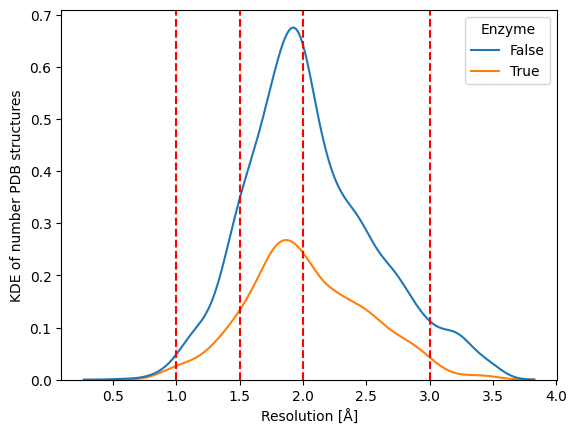

In [7]:
# Plotting the KDE Plot
sns.kdeplot(data=sites1_res, x='Resolution (Å)', hue = 'Enzyme')#, palette={False: 'black', True: 'blue'})
plt.axvline(x=1.0, color='red', linestyle='--', lw=1.5)
plt.axvline(x=1.5, color='red', linestyle='--', lw=1.5)
plt.axvline(x=2.0, color='red', linestyle='--', lw=1.5)
plt.axvline(x=3.0, color='red', linestyle='--', lw=1.5)
plt.xlabel('Resolution [Å]')
plt.ylabel('KDE of number PDB structures')

In [8]:
# Read the PDB file using BioPandas
pdb1 = PandasPdb().read_pdb('../data/7/a/7adh_A/7adh_A_Rlx.pdb')
pdb2 = PandasPdb().read_pdb('../data/7/a/7adh_A/7adh_A_Rlx.pdb')
atom_df = pdb2.df['ATOM']
atom_df.head(2)

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  SER           
1        ATOM            2                CA                  SER           

  chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
0        A               1            ...  -0.659   21.640   -7.277   
1        A               1            ...  -1.892   21.613   -6.517   

   occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0        NaN       NaN                                  N    NaN        17  
1        NaN       NaN                                  C    NaN        18  

[2 rows x 21 columns]

In [9]:
#pdb2table is a local copy of code to convert a PDB file into a table
import pdb2table as pdbdf
pdbtable = pdbdf.get_struc_atom_coords('../data/7/a/7adh_A/7adh_A_Rlx.pdb')
pdbtable.head(1)

serial atom_name altLoc resName chainID resNum iCode     x      y     z  \
0      1         N            SER       A      1       -0.65  21.64 -7.27   

  occupancy tempFactor segID element charge  
0       1.0        0.0             N

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2130/2454853987.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(pqrfilepath, sep='\s+', header=None)


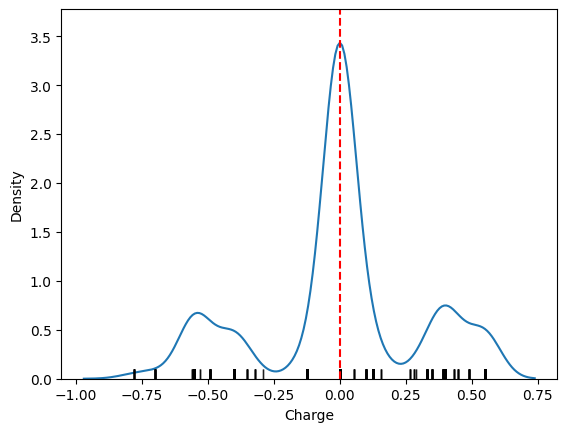

In [10]:
#PQR file is a table, it can be read using pandas.read_csv 
pqrfilepath = "../data/1/2/121p_A/121p_A.pqr"
df = pd.read_csv(pqrfilepath, sep='\s+', header=None)
df.columns = ['Type', 'Order', 'Atom', 'Res', 'ResN', 'x', 'y', 'z', 'charge', 'colx']
df = df[df['Type'] == 'ATOM']
df = df.drop(columns=['Type','Order', 'colx'])
# Plotting the KDE Plot
sns.kdeplot(data=df, x='charge')#, hue = "Res", lw=0.5)
sns.rugplot(df, x='charge', color="black", alpha=0.5).set(xlabel = "Charge", ylabel = "Density")
plt.axvline(x=0, color='red', linestyle='--', lw=1.5)

# Read PDB and PQR files

PDB: to extract HETATM values used to calculate the distance to the metal site and for electric field due to individual charges. 

PQR: to extract x, y, z, charge for residues and their atoms. 

In [12]:
#PDB file to table

def pdb2table(file_path):
    col_names_pdb = ['type','n', 'atom', 'resName', 'chain', 'resN', 'x', 'y', 'z', 
                 'occup', 'tempfctr', 'element', 'empty']
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                row_i = line.split()
                data.append(row_i)
    df = pd.DataFrame(data)
    if df.shape[1] == 12: 
        df.columns = col_names_pdb[:12]
        df = df.drop(columns = ['occup', 'tempfctr'])
    else:
        df.columns = col_names_pdb
        df = df.drop(columns = ['occup', 'tempfctr', 'empty'])
    return df
#example
pdbx = pdb2table('../data/1/s/1sum_B/1sum_B_Rlx.pdb'); pdbx[pdbx['type']== "HETATM"].head(2)

type     n atom resName chain resN       x       y       z element
3653  HETATM  3655   FE      FE     B  236  24.797  62.155  15.939      FE
3654  HETATM  3656   FE      FE     B  237  13.378  42.006   3.113      FE

In [13]:
#PQR file to table
def pqr2table(file_path):
    dfpqr = pd.read_csv(file_path, sep='\s+', header=None)
    dfpqr.columns = ['type', 'n', 'atom', 'resName', 'resN', 'x', 'y', 'z', 'charge', 'colx']
    dfpqr['n'] = pd.to_numeric(dfpqr['n'], errors='coerce')
    dfpqr['resN'] = pd.to_numeric(dfpqr['resN'], errors='coerce')
    dfpqr = dfpqr[dfpqr['type'] == 'ATOM']
    dfpqr = dfpqr.drop(columns=['colx'])
    return dfpqr
#example
pqrx = pqr2table('../data/1/s/1sum_B/1sum_B.pqr'); pqrx.head(2)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2130/986197301.py:3: SyntaxWarning: invalid escape sequence '\s'
  dfpqr = pd.read_csv(file_path, sep='\s+', header=None)


type    n atom resName  resN       x       y       z  charge
0  ATOM  1.0    N     ASN   2.0  34.989  69.585  13.281   -0.32
1  ATOM  2.0   CA     ASN   2.0  36.318  69.117  12.801    0.33

In [4]:
# HEATM from PDB, analyzed as single or cluster of metals 
def metal_dist(df, dist_max=5):
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df['z'] = pd.to_numeric(df['z'], errors='coerce')
    metpairs = pd.DataFrame(columns=['atoms', 'resName', 'resN', 'x', 'y', 'z'])
    clustered_metals = set()

    for i, j in combinations(range(len(df)), 2):
        metal1 = df.iloc[i]; metal2 = df.iloc[j]
        twometals = f"{metal1['atom']}{metal1['resN']}-{metal2['atom']}{metal2['resN']}"
        distance = np.linalg.norm(metal1[['x', 'y', 'z']] - metal2[['x', 'y', 'z']])

        if distance <= dist_max:
            if metal1['atom'] + str(metal1['resN']) not in clustered_metals and metal2['atom'] + str(metal2['resN']) not in clustered_metals:
                # Create a new cluster
                clustered_metals.add(metal1['atom'] + str(metal1['resN']))
                clustered_metals.add(metal2['atom'] + str(metal2['resN']))
                avg_coords = (metal1[['x', 'y', 'z']] + metal2[['x', 'y', 'z']]) / 2
                new_row = {'atoms': twometals, 'resName': metal1['resName'], 'resN': metal1['resN'],
                           'x': avg_coords['x'], 'y': avg_coords['y'], 'z': avg_coords['z']}
                metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)
            else:
                # Add metals to existing cluster
                cluster_index = metpairs[(metpairs['atoms'].str.contains(metal1['atom'] + str(metal1['resN']))) | 
                                          (metpairs['atoms'].str.contains(metal2['atom'] + str(metal2['resN'])))]
                if cluster_index.shape[0] > 0:
                    cluster_index = cluster_index.index[0]
                    cluster_row = metpairs.loc[cluster_index]
                    new_coords = (cluster_row[['x', 'y', 'z']] + metal1[['x', 'y', 'z']] + metal2[['x', 'y', 'z']]) / 3
                    metpairs.loc[cluster_index, ['x', 'y', 'z']] = new_coords
                    metpairs.loc[cluster_index, 'atoms'] += f"-{metal2['atom']}{metal2['resN']}"
                    clustered_metals.add(metal2['atom'] + str(metal2['resN']))

    # Add single atoms that aren't in any cluster
    for index, row in df.iterrows():
        if row['atom'] + str(row['resN']) not in clustered_metals:
            row['atoms'] = row['atom']
            row = row[['atoms', 'resName', 'resN', 'x', 'y', 'z']]
            metpairs = pd.concat([metpairs, row.to_frame().T], ignore_index=True)

    return metpairs
#example
pdb_dfx = pdb2table('../data/1/s/1sum_B/1sum_B_Rlx.pdb')[pdb2table('../data/1/s/1sum_B/1sum_B_Rlx.pdb')['type']=='HETATM']
metalx = metal_dist(pdb_dfx, 5); metalx.head(2)

/tmp/ipykernel_34257/450205633.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)


atoms resName resN          x        y         z
0  FE237-FE238-NI301      FE  237  12.634167  42.1875      2.62
1  FE240-FE241-FE242      FE  240    27.1335   26.358  7.431167

In [ ]:
#efield around metal sites
def charge_around_metal(pqrpath, pdbpath, cluster_maxdist=5, atomdist_shell=15):
    dfpdb = pdb2table(pdbpath)
    dfpdb = dfpdb[dfpdb['type'] == "HETATM"]
    dfmetals = metal_dist(dfpdb, cluster_maxdist)
    dfpqr = pqr2table(pqrpath)
    chain = dfpdb.iloc[0, 4]

    def compute_distance(atom1, atom2):
        pos1 = atom1[['x', 'y', 'z']].values
        pos2 = atom2[['x', 'y', 'z']].values
        distance = np.linalg.norm(pos1 - pos2)
        dir_vector = (pos1 - pos2) / distance
        ef = -abs(atom1['charge'] / distance) if atom1['charge'] < 0 else abs(atom1['charge'] / distance)
        ef_dir = abs(dir_vector) * ef
        return distance, dir_vector, ef, ef_dir

    def process_pair(i):
        atom1 = dfpqr.iloc[i[0]]
        atom2 = dfmetals.iloc[i[1]]
        distance, dir_vector, ef, ef_dir = compute_distance(atom1, atom2)
        if distance <= atomdist_shell:
            return {
                'n': atom1[1], 'atom': atom1[2], 'resName': atom1[3], 'resN': atom1[4], 'chain': chain, 'metal': atom2[0], 'metalN': atom2[2],
                'x': atom1[5], 'y': atom1[6], 'z': atom1[7], 'xm': atom2[3], 'ym': atom2[4], 'zm': atom2[5],
                'distance': distance, 'rx': dir_vector[0], 'ry': dir_vector[1], 'rz': dir_vector[2],
                'charge': atom1[8], 'E': ef, 'Ex': ef_dir[0], 'Ey': ef_dir[1], 'Ez': ef_dir[2]
            }
        return None

    i_atoms = range(len(dfpqr))
    i_metals = range(len(dfmetals))
    comb_atm_metal = list(itertools.product(i_atoms, i_metals))

    results = Parallel(n_jobs=-1)(delayed(process_pair)(i) for i in comb_atm_metal)
    atoms_near_metals = pd.DataFrame([res for res in results if res is not None])

    return atoms_near_metals

# Example usage
efield_dfx = charge_around_metal('../data/1/s/1sum_B/1sum_B.pqr', '../data/1/s/1sum_B/1sum_B_Rlx.pdb', 5, 15)
print(efield_dfx.shape)
efield_dfx.head(2)

/tmp/ipykernel_34257/450205633.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)
/tmp/ipykernel_34257/1409850256.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:26: FutureWa

/tmp/ipykernel_34257/1409850256.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

(2724, 22)


n atom resName  resN chain metal metalN       x       y       z  ...  \
0  1.0    N     ASN   2.0     B    FE    236  34.989  69.585  13.281  ...   
1  2.0   CA     ASN   2.0     B    FE    236  36.318  69.117  12.801  ...   

       zm   distance        rx        ry        rz  charge         E       Ex  \
0  15.939  12.889792  0.790703  0.576425 -0.206210   -0.32 -0.024826 -0.01963   
1  15.939  13.822081  0.833521  0.503687 -0.227028    0.33  0.023875  0.01990   

         Ey        Ez  
0 -0.014310 -0.005119  
1  0.012025  0.005420  

[2 rows x 22 columns]

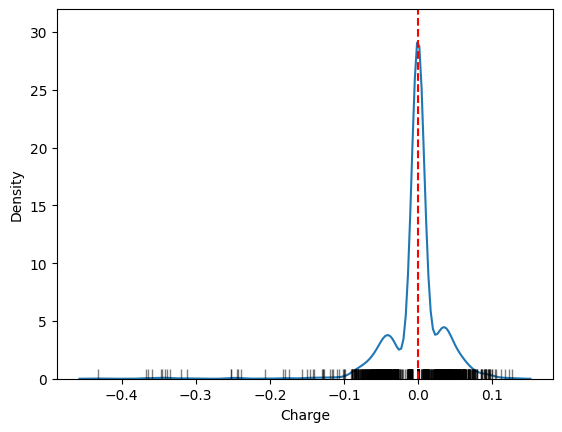

In [27]:
# Plotting the KDE Plot
sns.kdeplot(efield_dfx, x='E')#, hue = "Res", lw=0.5)
sns.rugplot(efield_dfx, x='E', color="black", alpha=0.5).set(xlabel = "Charge", ylabel = "Density")
plt.axvline(x=0, color='red', linestyle='--', lw=1.5)

In [28]:
# Example: 7adh: 2Zn, 121p: 1Mg,   4b3e:1Fe-1Zn,  1sum: 8Fe-1Ni
pdb7adh = '../data/7/a/7adh_A/7adh_A_Rlx.pdb'; pdb121p = '../data/1/2/121p_A/121p_A_Rlx.pdb'
pdb4b3e = '../data/4/b/4b3e_G/4b3e_G_Rlx.pdb'; pdb1sum = '../data/1/s/1sum_B/1sum_B_Rlx.pdb'

pqr7adh = '../data/7/a/7adh_A/7adh_A.pqr'; pqr121p = '../data/1/2/121p_A/121p_A.pqr'
pqr4b3e = '../data/4/b/4b3e_G/4b3e_G.pqr'; pqr1sum = '../data/1/s/1sum_B/1sum_B.pqr'

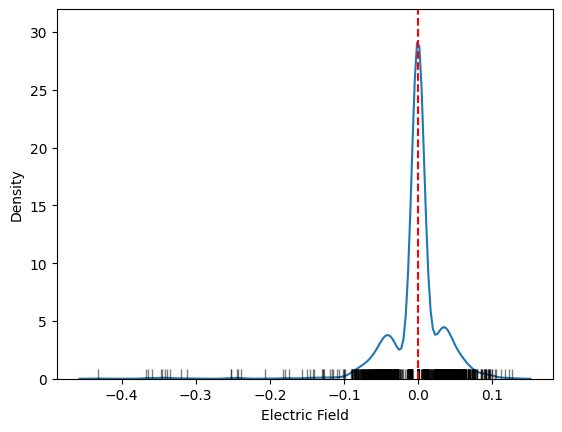

In [7]:
# Plotting the KDE Plot
sns.kdeplot(efield_dfx, x='E')#, hue = "Res", lw=0.5)
sns.rugplot(efield_dfx, x='E', color="black", alpha=0.5).set(xlabel = "Electric Field", ylabel = "Density")
plt.axvline(x=0, color='red', linestyle='--', lw=1.5)

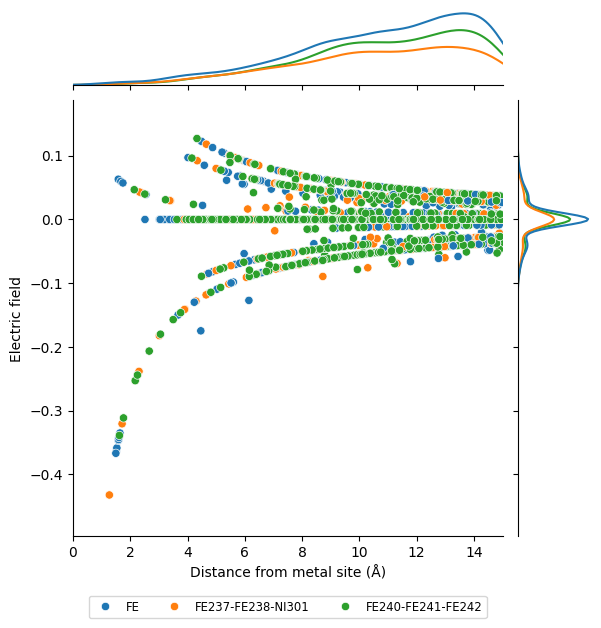

In [8]:
df = efield_dfx.copy()
g = sns.jointplot(data=df, x="distance", y="E", hue="metal", kind='scatter',
                  marginal_kws={'fill':False})
#plt.ylim(-0.5, 0.5)
plt.xlim(0, 15)
plt.xlabel("Distance from metal site (Å)")
plt.ylabel("Electric field")
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol = 4, fontsize='small')
plt.show()

## Recover files with .pdb or pqr extension

In [ ]:
import os
def getall_efield(directory):
    all_data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.pdb'):
                pdbpath = os.path.join(root, file)
                pqrpath = pdbpath.replace("_Rlx.pdb", ".pqr")
                file_name = os.path.splitext(os.path.basename(file))[0].replace("_Rlx", "")
                try:
                    df = charge_around_metal(pqrpath, pdbpath, 5, 15) #obtain data for single PDB
                    df['structure'] = file_name
                    all_data.append(df)
                except:
                    print("Not enough data for " + file_name)
    
    full_df = pd.concat(all_data, ignore_index=True)
    return full_df


In [ ]:
# Example
root_directory = "../data"
all_efields = getall_efield(root_directory)
all_efields.to_csv('../results/efields15.csv', index=False)
all_efields.head()

/tmp/ipykernel_34257/1409850256.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_34257/1409850256.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Index(['n', 'atom', 'resName', 'resN', 'chain', 'metal', 'metalN', 'x', 'y',
       'z', 'xm', 'ym', 'zm', 'distance', 'rx', 'ry', 'rz', 'charge', 'E',
       'Ex', 'Ey', 'Ez', 'structure', 'sites', 'metalref'],
      dtype='object')


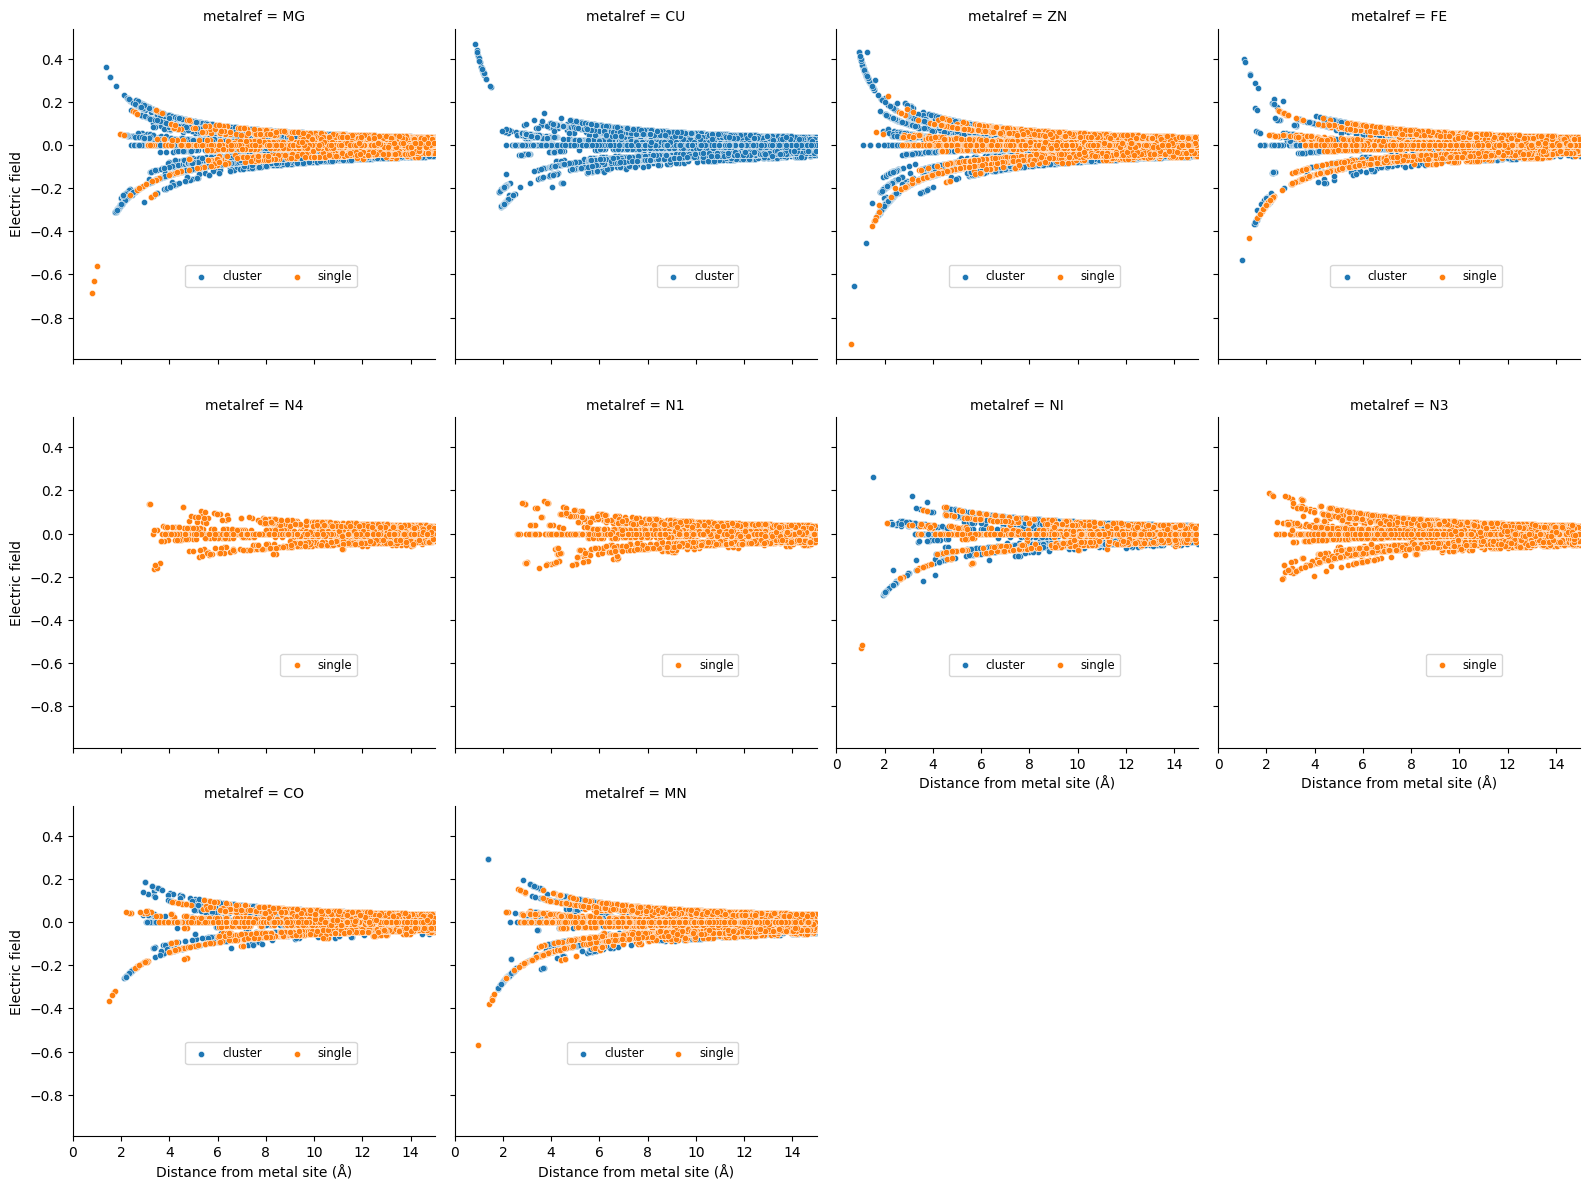

In [21]:
efields_df = pd.read_csv('../results/efields15.csv')
efields_df['sites'] = efields_df['metal'].apply(lambda x: 'single' if len(x) > 5 else 'cluster')
efields_df['metalref'] = efields_df['metal'].str[:2]
print(efields_df.columns)

# Create the FacetGrid with hue as 'metal'
g = sns.FacetGrid(efields_df, col="metalref", col_wrap=4, hue="sites", height=4, aspect=1)
g.map(sns.scatterplot, "distance", "E", s=20)

# Set limits and labels
g.set(xlim=(0, 15))
g.set_axis_labels("Distance from metal site (Å)", "Electric field")

# Adjust the legend
for ax in g.axes.flat:
    ax.legend(loc='lower right', bbox_to_anchor=(0.8, 0.2), ncol=4, fontsize='small')

# Show the plot
plt.show()

In [34]:
# Electric field by residue
def elecfield_byres(pqrpath, pdbpath, cluster_maxdist=5, atomdist_shell=10):
    ef_dfx = charge_around_metal(pqrpath, pdbpath, cluster_maxdist, atomdist_shell)
    ef_dftemp = efield_dfx[efield_dfx['atom', 'resName', 'resN', 'metal', 'distance', 'charge', 'E']]
    ef_dftemp = efield_dfx[efield_dfx['atom', 'resName', 'resN', 'metal', 'distance', 'charge', 'E']]